Dataset Shape: (27901, 18)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration              

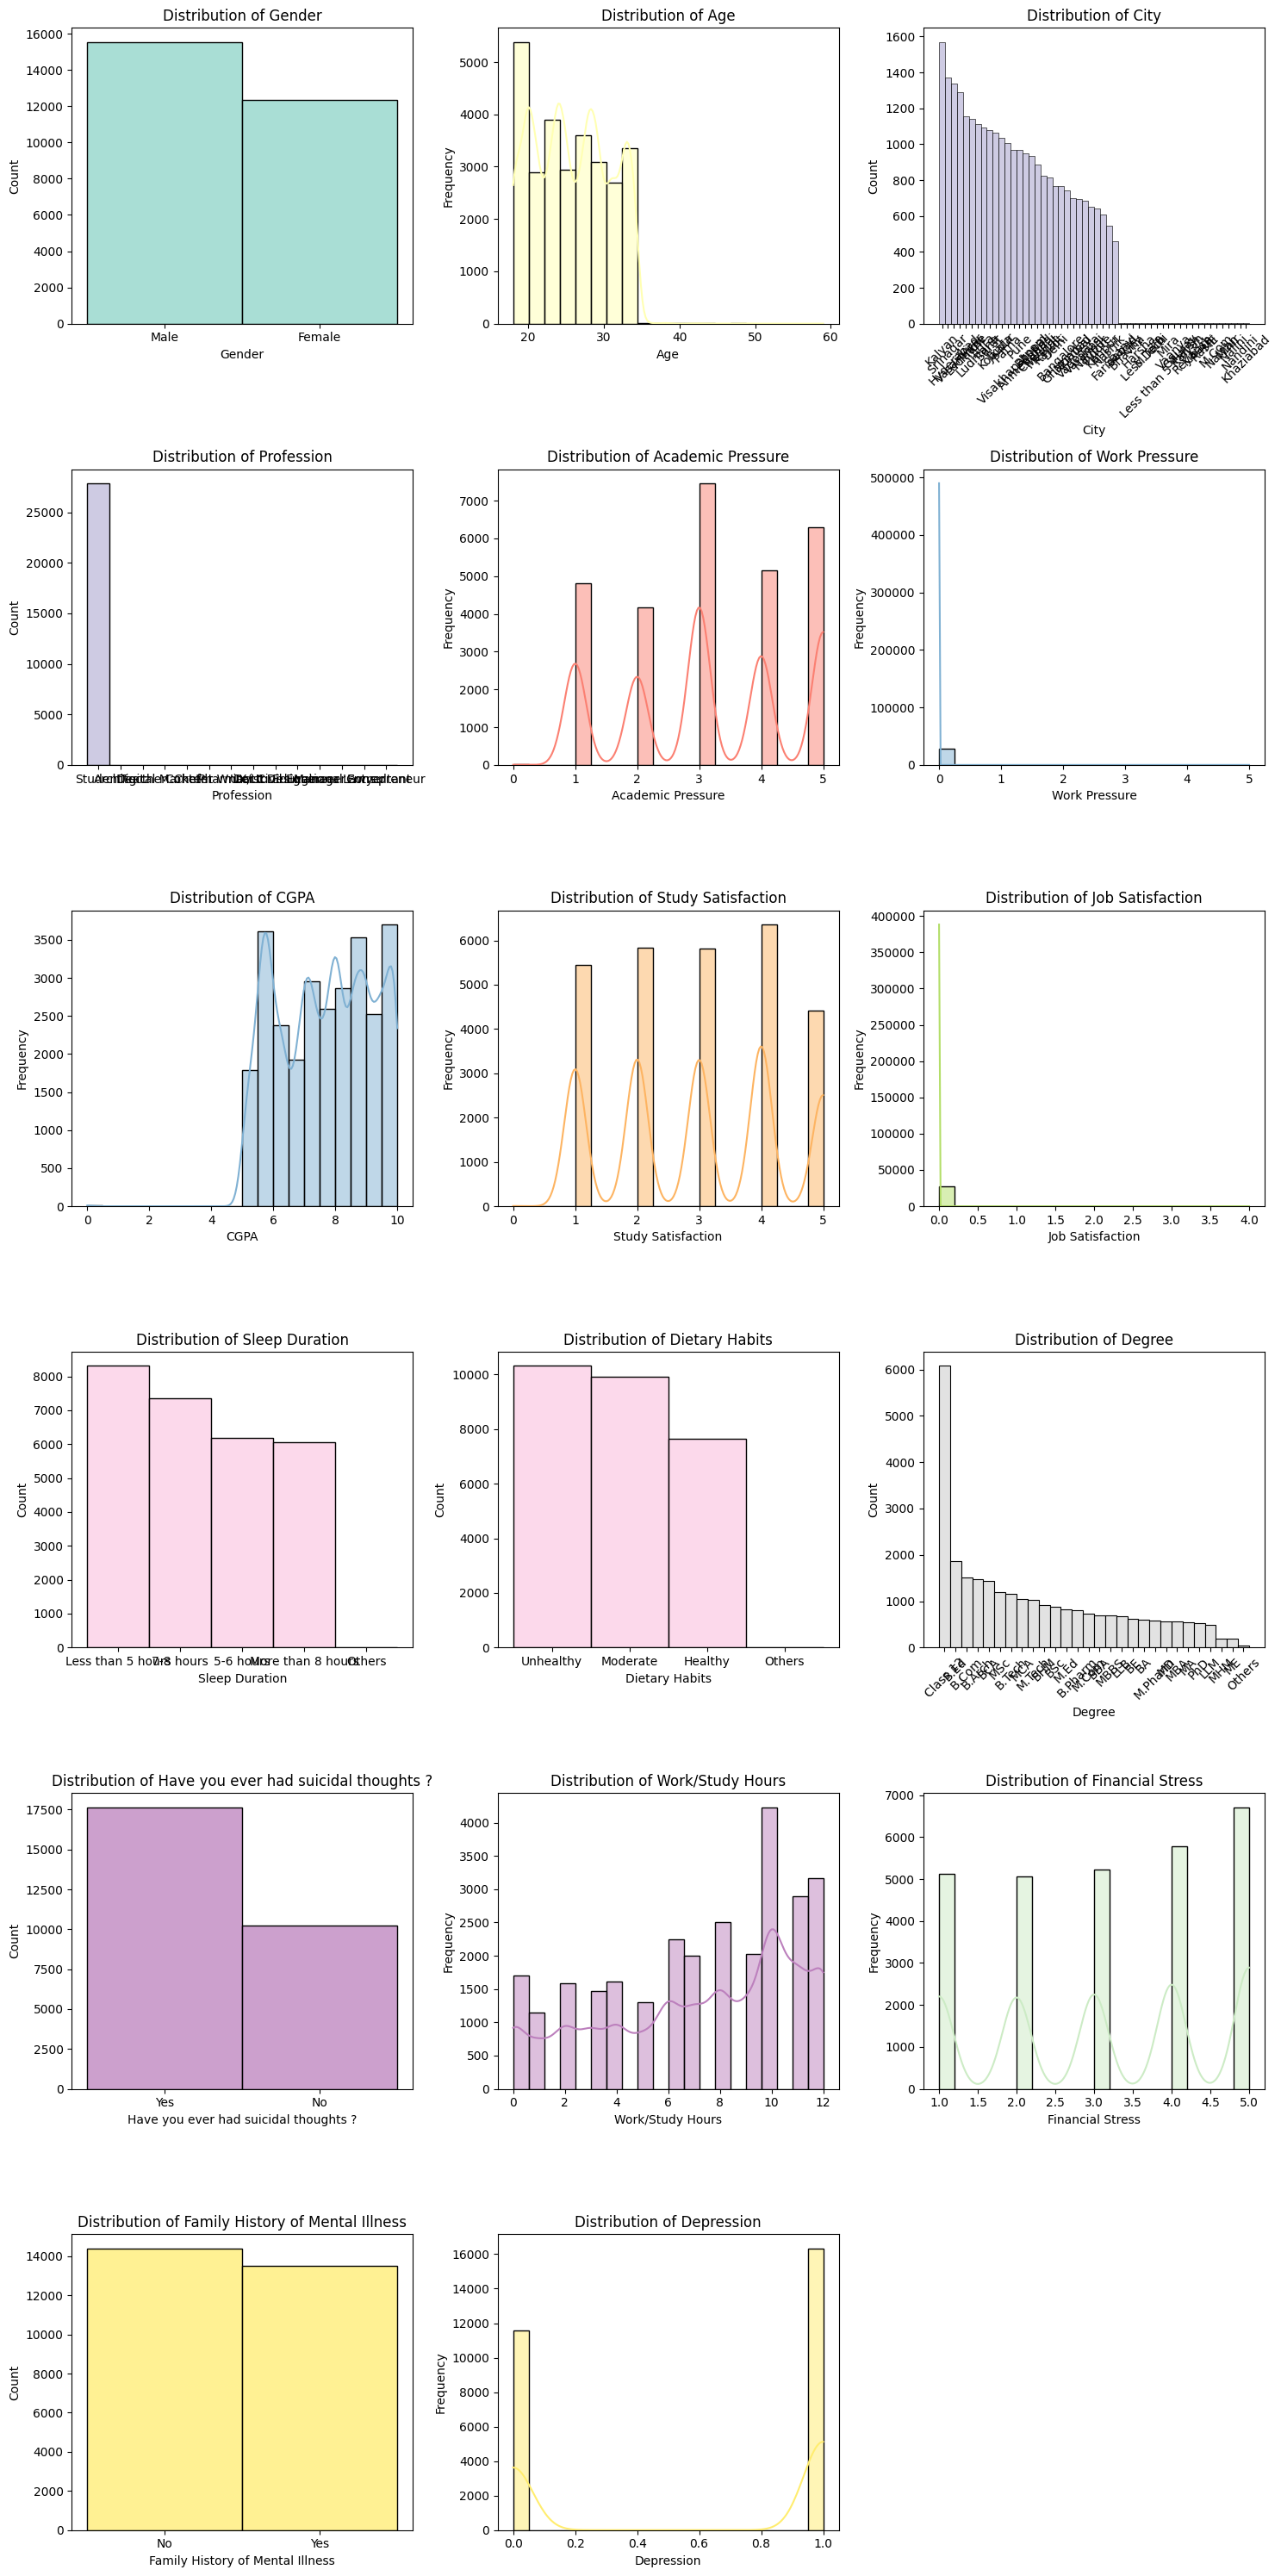

In [10]:
####1.Missing Data Handling & Encoding

##1.Data Cleaning (Missing & Duplicate Handling)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import os

# Load the dataset
df = pd.read_csv('Student Depression Dataset.csv')

# Display basic info to understand the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

# Step 1: Check for Missing Values
missing_values = df.isna().sum()
print("\nMissing Values per Column:")
print(missing_values)

# Percentage of missing values
missing_percent = (missing_values / len(df)) * 100
print("\nMissing Values Percentage:")
print(missing_percent)

# Handling Missing Values
# If any missing, impute numerical columns with median (robust to outliers), categorical with mode
if missing_values.sum() > 0:
    # Numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    fill_values = {}
    for col in num_cols:
        if missing_values[col] > 0:
            fill_values[col] = df[col].median()

    # Categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if missing_values[col] > 0:
            fill_values[col] = df[col].mode()[0]

    # Apply fillna to the entire DataFrame at once
    df.fillna(fill_values, inplace=True)

    print("\nMissing Values After Handling:")
    print(df.isna().sum())
else:
    print("\nNo missing values found. No imputation needed.")

# Step 2: Check for Duplicates
duplicates_count = df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicates_count)

# Handling Duplicates
if duplicates_count > 0:
    df = df.drop_duplicates()
    print("\nDuplicates Removed. New Shape:", df.shape)
else:
    print("\nNo duplicates found. No removal needed.")

# Save the cleaned dataset (for group pipeline integration)
df.to_csv('cleaned_student_depression_dataset.csv', index=False)
print("\nCleaned dataset saved as 'cleaned_student_depression_dataset.csv'")



## EDA Visualizations for Handeling Missing Data


# List of all columns (excluding 'id')
all_cols = ['Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure',
            'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
            'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
            'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness',
            'Depression']

# Create a figure with subplots
n_cols = len(all_cols)
n_rows = (n_cols + 2) // 3
plt.figure(figsize=(15, 5 * n_rows))

# Generate histograms for each column
for i, col in enumerate(all_cols, 1):
    plt.subplot(n_rows, 3, i)
    if df[col].dtype in ['float64', 'int64']:  # Numerical columns
        sns.histplot(data=df, x=col, bins=20, kde=True, color=plt.cm.Set3(i / n_cols))
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    else:  # Categorical/Binary columns
        # Create a DataFrame with value counts and use the original column name
        cat_data = df[col].value_counts().reset_index()
        cat_data.columns = [col, 'count'] # Rename columns
        sns.histplot(data=cat_data, x=col, weights='count',
                     color=plt.cm.Set3(i / n_cols), discrete=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45 if col == 'City' or col == 'Degree' else 0)

# Adjust layout to prevent overlap
plt.tight_layout()

# Create the directory if it doesn't exist
output_dir = 'results/eda_visualizations/member_1'
os.makedirs(output_dir, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_dir, 'all_columns_histogram.png'))
plt.show()

In [7]:
%pip install category_encoders

Original Dataset (First 5 Rows of Categorical Columns):
   gender suicidal_thoughts family_history profession     sleep_duration  \
0    Male               Yes             No    Student          5-6 hours   
1  Female                No            Yes    Student          5-6 hours   
2    Male                No            Yes    Student  Less than 5 hours   
3  Female               Yes            Yes    Student          7-8 hours   
4  Female               Yes             No    Student          5-6 hours   

  dietary_habits   degree           city  
0        Healthy  B.Pharm  Visakhapatnam  
1       Moderate      BSc      Bangalore  
2        Healthy       BA       Srinagar  
3       Moderate      BCA       Varanasi  
4       Moderate   M.Tech         Jaipur  

gender Encoding Mapping: {'Female': np.int64(0), 'Male': np.int64(1)}

suicidal_thoughts Encoding Mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

family_history Encoding Mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

--- On

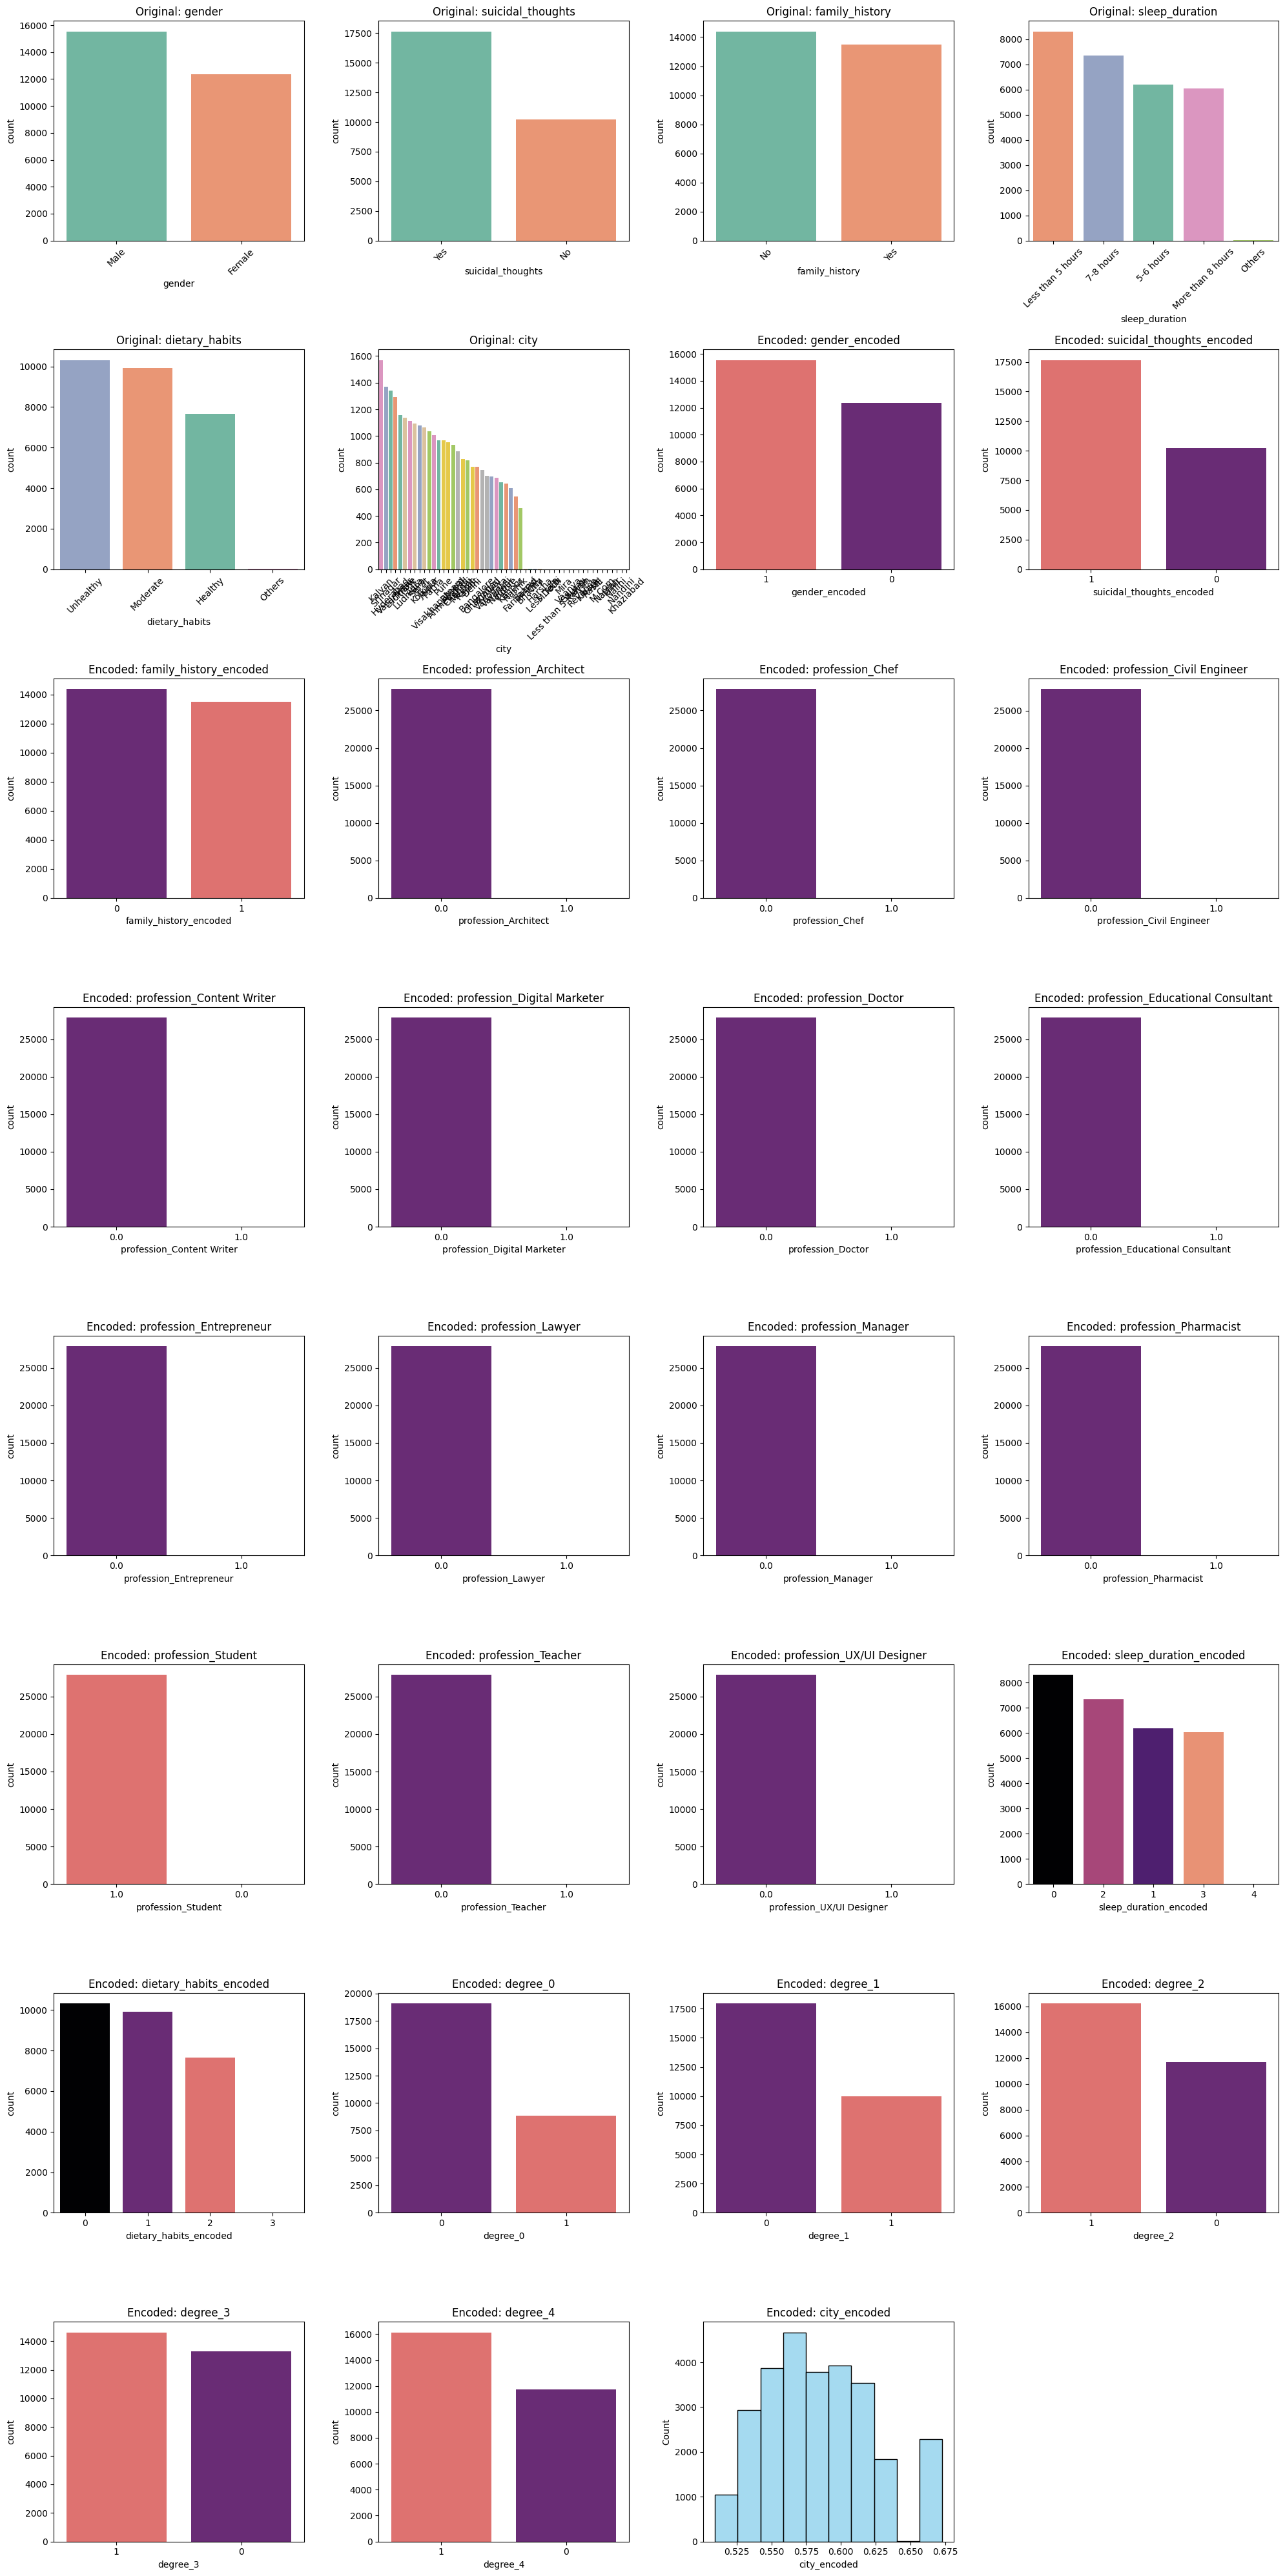


Fully encoded dataset (containing only encoded and non-categorical columns) saved as 'fully_encoded_student_depression_dataset.csv'


In [8]:
##2.Encoding Categorical Variables

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os

# Import category_encoders separately, assuming it's installed or will be
try:
    from category_encoders import BinaryEncoder, TargetEncoder
    category_encoders_available = True
except ImportError:
    print("Warning: category_encoders not found. Binary and Target encoding will be skipped.")
    category_encoders_available = False


# Load the dataset with error handling
try:
    df = pd.read_csv('cleaned_student_depression_dataset.csv')
    if df.empty:
        raise ValueError("Dataset is empty. Check file path or content.")
except FileNotFoundError:
    print("Error: 'cleaned_student_depression_dataset.csv' not found. Ensure it exists in the working directory.")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Rename categorical columns for clarity and consistency
column_renames = {
    'Gender': 'gender',
    'Have you ever had suicidal thoughts ?': 'suicidal_thoughts',
    'Family History of Mental Illness': 'family_history',
    'Profession': 'profession',
    'Sleep Duration': 'sleep_duration',
    'Dietary Habits': 'dietary_habits',
    'Degree': 'degree',
    'City': 'city'
}
df.rename(columns=column_renames, inplace=True)

# Define categorical columns and verify their presence
cat_cols = ['gender', 'suicidal_thoughts', 'family_history', 'profession', 'sleep_duration', 'dietary_habits', 'degree', 'city']
missing_cols = [col for col in cat_cols if col not in df.columns]
if missing_cols:
    print(f"Error: The following columns are missing from the dataset: {missing_cols}")
    exit()

# Display original data sample
print("Original Dataset (First 5 Rows of Categorical Columns):")
print(df[cat_cols].head())

# --- Encoding Section ---

# 1. Label Encoding: Binary columns (gender, suicidal_thoughts, family_history)
le = LabelEncoder()
label_cols = ['gender', 'suicidal_thoughts', 'family_history']
for col in label_cols:
    if col in df.columns:
        df[f'{col}_encoded'] = le.fit_transform(df[col])
        print(f"\n{col} Encoding Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    else:
        print(f"Warning: {col} not found, skipping label encoding.")

# 2. One-Hot Encoding: profession
print("\n--- One-Hot Encoding ---")
print("Column: profession")
if 'profession' in df.columns:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe_encoded = ohe.fit_transform(df[['profession']])
    ohe_cols = ohe.get_feature_names_out(['profession'])
    ohe_df_encoded = pd.DataFrame(ohe_encoded, columns=ohe_cols, index=df.index)
    df = pd.concat([df, ohe_df_encoded], axis=1)
    df.drop('profession', axis=1, inplace=True)
    print("\nOne-Hot Encoded Columns (First 5 Rows):")
    print(df[ohe_cols].head())
else:
    print("Warning: 'profession' not found, skipping One-Hot Encoding.")

# 3. Ordinal Encoding: sleep_duration, dietary_habits
ordinal_mapping_sleep = {'Less than 5 hours': 0, '5-6 hours': 1, '7-8 hours': 2, 'More than 8 hours': 3, 'Others': 4}
ordinal_mapping_diet = {'Unhealthy': 0, 'Moderate': 1, 'Healthy': 2, 'Others': 3}
if 'sleep_duration' in df.columns:
    df['sleep_duration_encoded'] = df['sleep_duration'].map(ordinal_mapping_sleep).astype('Int64')
if 'dietary_habits' in df.columns:
    df['dietary_habits_encoded'] = df['dietary_habits'].map(ordinal_mapping_diet).astype('Int64')
print("\nOrdinal Encoded Columns Added (sleep_duration_encoded, dietary_habits_encoded):")
print(df[['sleep_duration_encoded', 'dietary_habits_encoded']].head())

# 4. Binary Encoding: degree
if category_encoders_available and 'degree' in df.columns:
    try:
        be = BinaryEncoder(cols=['degree'])
        df_binary = be.fit_transform(df[['degree']])
        df = pd.concat([df, df_binary], axis=1)
        df.drop('degree', axis=1, inplace=True)
        binary_cols = [col for col in df_binary.columns if col.startswith('degree_')]
        print("\nBinary Encoded Degree Columns Added:", binary_cols)
        print(df[binary_cols].head())
    except Exception as e:
        print(f"Error in Binary Encoding: {e}")
else:
    print("Warning: 'degree' not found or category_encoders not available, skipping Binary Encoding.")


# 5. Target Encoding: city (assuming 'Depression' is the target column)
if category_encoders_available and 'city' in df.columns and 'Depression' in df.columns:
    try:
        te = TargetEncoder(cols=['city'])
        df['city_encoded'] = te.fit_transform(df[['city']], df['Depression'])
        print("\nTarget Encoded City Column Added (city_encoded):")
        print(df[['city_encoded']].head())
    except Exception as e:
        print(f"Error in Target Encoding: {e}")
else:
    print("Warning: 'city' or 'Depression' not found or category_encoders not available, skipping Target Encoding.")


# Display encoded dataset snippet
encoded_cols = [col for col in df.columns if '_encoded' in col or col.startswith('profession_') or col.startswith('degree_')]
print("\nEncoded Dataset (First 5 Rows of Encoded Columns):")
print(df[encoded_cols].head())

# --- EDA Visualizations for All Categorical Columns ---

# Create subplots for original and encoded categorical columns
original_cols = [col for col in cat_cols if col in df.columns]
n_cols = len(original_cols)
encoded_cols = [col for col in df.columns if '_encoded' in col or col.startswith('profession_') or col.startswith('degree_')]
n_encoded = len(encoded_cols)
total_plots = n_cols + n_encoded
n_rows = (total_plots + 3) // 4  # Calculate rows needed (4 plots per row)
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))
axes = axes.ravel()

# Plot original categorical columns
for i, col in enumerate(original_cols):
    sns.countplot(x=col, data=df, ax=axes[i], hue=col, palette='Set2', order=df[col].value_counts().index, legend=False)
    axes[i].set_title(f'Original: {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Plot encoded categorical columns
for i, col in enumerate(encoded_cols):
    if 'city_encoded' in col:
        sns.histplot(df[col], bins=10, ax=axes[i + n_cols], color='skyblue')
    else:
        sns.countplot(x=col, data=df, ax=axes[i + n_cols], hue=col, palette='magma', order=df[col].value_counts().index, legend=False)
    axes[i + n_cols].set_title(f'Encoded: {col}')
    axes[i + n_cols].tick_params(axis='x', rotation=0)

# Remove unused subplots
for j in range(total_plots, len(axes)):
    axes[j].remove()

plt.tight_layout()

# Create the directory if it doesn't exist
output_dir = 'results/eda_visualizations/member_1'
os.makedirs(output_dir, exist_ok=True)

# Save the visualizations
plt.savefig(os.path.join(output_dir, 'categorical_encoding_visualizations.png'))
plt.show()

# Select only encoded columns and non-categorical columns (e.g., 'Depression') for saving
non_categorical_cols = [col for col in df.columns if col not in cat_cols and col not in encoded_cols]  # e.g., 'Depression'
final_cols = encoded_cols + non_categorical_cols
df_encoded_only = df[final_cols]

# Save the fully encoded dataset with only encoded columns and non-categorical columns
df_encoded_only.to_csv('fully_encoded_student_depression_dataset.csv', index=False)
print("\nFully encoded dataset (containing only encoded and non-categorical columns) saved as 'fully_encoded_student_depression_dataset.csv'")